## Uploading, Importing, and Preprocesing Dataset

###### Upload Dataset

In [ ]:
!wget -P /content/drive/MyDrive/Data http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [ ]:
!unzip /content/drive/MyDrive/Data/annotations_trainval2017.zip -d /content/drive/MyDrive/Data/

In [ ]:
!wget -P /content/drive/MyDrive/Data http://images.cocodataset.org/zips/val2017.zip

In [ ]:
!unzip /content/drive/MyDrive/Data/val2017.zip -d /content/drive/MyDrive/Data

##### Import Models

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
import pickle
import pandas as pd
import random
import sys
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##### Preprocess Dataset

In [ ]:
with open('/content/drive/MyDrive/Data/annotations/captions_val2017.json') as f:
  data = json.load(f)
  del data["licenses"]
  del data["info"]
  images = data["images"]
  captions = data["annotations"]

In [ ]:
images_pd = pd.DataFrame.from_dict(images)
captions_pd = pd.DataFrame.from_dict(captions)
images_pd.drop(['license', 'coco_url', 'height', 'width', "date_captured", "flickr_url"], inplace=True, axis=1)
images_pd = images_pd.sort_values("id").reset_index()
captions_pd = captions_pd.sort_values("image_id").reset_index()
images_pd.drop(["index"], inplace=True, axis=1)
captions_pd.drop(["index", "id"], inplace=True, axis=1)

def match(id):
  row = images_pd.loc[images_pd['id'] == id]
  file_name = row["file_name"].item()
  return file_name
blup = pd.DataFrame()
blup["file-name"] = captions_pd["image_id"].apply(lambda x: match(x))

dataset = pd.concat([blup, captions_pd], axis=1)
dataset = dataset.drop(["image_id"], axis=1)

In [ ]:
train, test = train_test_split(dataset, test_size=0.2)
train = train.reset_index()
test = test.reset_index()

In [ ]:
train = train.drop(["index"], axis=1)
test = test.drop(["index"], axis=1)

In [ ]:
num_images_train = len(train)
file_names_train = train["file-name"]
captions_train = train["caption"]

num_images_test = len(test)
file_names_test = test["file-name"]
captions_test = test["caption"]

##### Helper functions

In [ ]:
def load_image(path, size=None):
    img = Image.open(path)
    if size != None:
        img = img.resize(size=size, resample=Image.LANCZOS)
    img = np.array(img)
    img = img / 255.0
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

def show_image(idx, train):
    if train:
        filename = file_names_train[idx]
        captions = captions_train[idx]
        path = f"/content/drive/MyDrive/Data/val2017/{file_names_train[idx]}"
    else:
        filename = file_names_test[idx]
        captions = captions_test[idx]
        path = f"/content/drive/MyDrive/Data/val2017/{file_names_test[idx]}"
    print("Actual: ", captions[5:-5])
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    return path

Actual:  We are looking up at an old clock tower.


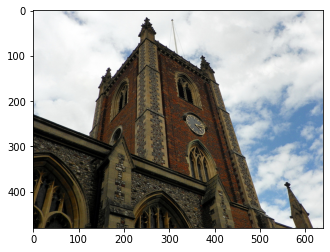

'/content/drive/MyDrive/Data/val2017/000000247806.jpg'

In [ ]:
show_image(random.randint(0, num_images_test), train=False)

## Create Model

##### VGG-19 Encoder

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
transfer_layer = image_model.get_layer('fc2')

In [ ]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

##### Process images through encoder

In [ ]:
def print_progress(count, max_count):
    pct_complete = count / max_count
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
def process_images(train, batch_size=32):
    if train:
      file_names = file_names_train
    else:
      file_names = file_names_test
    
    num_images = len(file_names)

    shape = (batch_size, 224, 224, 3)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    shape = (num_images, 4096)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    start = 0

    while start < num_images:
        print_progress(count=start, max_count=num_images)

        end = start + batch_size

        if end > num_images:
            end = num_images

        actual_batch_size = end - start

        for i, filename in enumerate(file_names[start:end]):
            path = f"/content/drive/MyDrive/Data/val2017/{filename}"
            img = load_image(path, size=(224, 224))
            image_batch[i] = img

        transfer_values_batch = image_model_transfer.predict(image_batch[0:actual_batch_size])
        transfer_values[start:end] = transfer_values_batch[0:actual_batch_size]

        start = end
    if train:
        with open('/content/drive/MyDrive/Data/transfer_values_train.pickle', 'wb') as f:
          pickle.dump(transfer_values, f)
    else:
        with open('/content/drive/MyDrive/Data/transfer_values_test.pickle', 'wb') as f:
          pickle.dump(transfer_values, f)
    return transfer_values

In [ ]:
%time
transfer_values_train = process_images(train=True)
transfer_values_test = process_images(train=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
- Progress: 99.8%

##### Tokenizer

In [ ]:
mark_start = 'ssss '
mark_end = ' eeee'
captions_train = [mark_start + caption + mark_end
                    for caption in captions_train]
captions_test = [mark_start + caption + mark_end
                    for caption in captions_test]
num_words = 10000

In [ ]:
tokenizer_train = Tokenizer(num_words=num_words)
tokenizer_test = Tokenizer(num_words=num_words)

tokenizer_train.fit_on_texts(captions_train)
tokenizer_test.fit_on_texts(captions_test)

word_index_dict_train = dict(zip(tokenizer_train.word_index.keys(), tokenizer_train.word_index.values()))
word_index_dict_test = dict(zip(tokenizer_test.word_index.keys(), tokenizer_test.word_index.values()))

index_word_dict_train = dict(zip(tokenizer_train.word_index.values(), tokenizer_train.word_index.keys()))
index_word_dict_test = dict(zip(tokenizer_test.word_index.values(), tokenizer_test.word_index.keys()))

In [ ]:
len(captions_train)

20011

In [ ]:
token_start = word_index_dict_train[mark_start.strip()]
token_end = word_index_dict_train[mark_end.strip()]

In [ ]:
tokens_train = tokenizer_train.texts_to_sequences(captions_train)
tokens_test = tokenizer_train.texts_to_sequences(captions_test)

##### Create inputs for decode in batches

In [ ]:
with open('/content/drive/MyDrive/Data/transfer_values_train.pickle', 'rb') as f:
    transfer_values_train = pickle.load(f)

with open('/content/drive/MyDrive/Data/transfer_values_test.pickle', 'rb') as f:
    transfer_values_test = pickle.load(f)

In [ ]:
def batch_generator_test(batch_size):
    while True:
        idx = np.random.randint(num_images_test,
                                size=batch_size)
        transfer_values = transfer_values_test[idx]

        tokens = []
        for i in idx:
            bruhh = tokens_test[i]
            tokens.append(bruhh)

        num_tokens = [len(t) for t in tokens]
        max_tokens = np.max(num_tokens)
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')

        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        yield (x_data, y_data)

In [ ]:
def batch_generator(batch_size):
    while True:
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        transfer_values = transfer_values_train[idx]

        tokens = []
        for i in idx:
            bruhh = tokens_train[i]
            tokens.append(bruhh)

        num_tokens = [len(t) for t in tokens]
        max_tokens = np.max(num_tokens)
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')

        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        yield (x_data, y_data)

In [ ]:
batch_size = 384

In [ ]:
generator = batch_generator(batch_size=batch_size)
generator_test = batch_generator_test(batch_size=batch_size)

##### Create Decoder Model

In [ ]:
steps_per_epoch = 52 #int(len(captions_train) / batch_size)

In [ ]:
num_words = 10000

In [ ]:
embedding_size = 128
state_size = 512
transfer_values_input = Input(shape=(4096,), name='transfer_values_input')
decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=num_words, output_dim=embedding_size, name='decoder_embedding')
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)
decoder_dense = Dense(num_words, activation='softmax', name='decoder_output')

In [ ]:
initial_state = decoder_transfer_map(transfer_values_input)
net = decoder_input
net = decoder_embedding(net)
net = decoder_gru1(net, initial_state=initial_state)
net = decoder_gru2(net, initial_state=initial_state)
net = decoder_gru3(net, initial_state=initial_state)
decoder_output = decoder_dense(net)

In [ ]:
decoder = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [ ]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 transfer_values_input (InputLa  [(None, 4096)]      0           []                               
 yer)                                                                                             
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 128)    1280000     ['decoder_input[0][0]']          
                                                                                                  
 decoder_transfer_map (Dense)   (None, 512)          2097664     ['transfer_values_input[0][

In [ ]:
decoder.compile(optimizer=RMSprop(lr=1e-3), loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Train

In [ ]:
history = decoder.fit(generator, steps_per_epoch=steps_per_epoch, epochs=100, validation_data=generator_test)

Epoch 1/100
52/52 [==============================] - 10s 192ms/step - loss: 2.3386
Epoch 2/100
52/52 [==============================] - 11s 204ms/step - loss: 2.1812
Epoch 3/100
52/52 [==============================] - 11s 216ms/step - loss: 1.9224
Epoch 4/100
52/52 [==============================] - 11s 203ms/step - loss: 1.8835
Epoch 5/100
52/52 [==============================] - 10s 201ms/step - loss: 1.7744
Epoch 6/100
52/52 [==============================] - 10s 199ms/step - loss: 1.6695
Epoch 7/100
52/52 [==============================] - 11s 207ms/step - loss: 1.5475
Epoch 8/100
52/52 [==============================] - 10s 197ms/step - loss: 1.5504
Epoch 9/100
52/52 [==============================] - 10s 193ms/step - loss: 1.5314
Epoch 10/100
52/52 [==============================] - 11s 205ms/step - loss: 1.3904
Epoch 11/100
52/52 [==============================] - 10s 200ms/step - loss: 1.3889
Epoch 12/100
52/52 [==============================] - 10s 202ms/step - loss: 1.3519
E

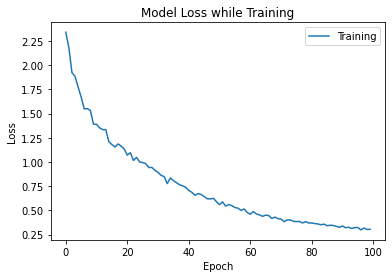

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val'])
plt.title('Model Loss while Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

## Finished Product

In [ ]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=(224, 224))
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = image_model_transfer.predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    output_text = ''
    count_tokens = 0
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = " " if token_int == 0 else index_word_dict_train[token_int]
        output_text += " " + sampled_word
        count_tokens += 1
    output_tokens = decoder_input_data[0]
    print("Predicted caption: ", output_text[:-5])

Actual:  a train in a rural area covered with heavy snow


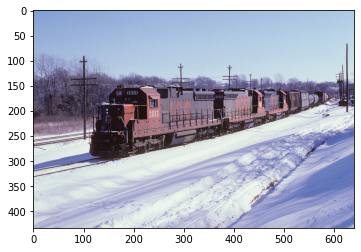

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Predicted caption:   a train is coming down the tracks on a snowy day eee
Actual:  two people sitting in a field with open umbrellas 


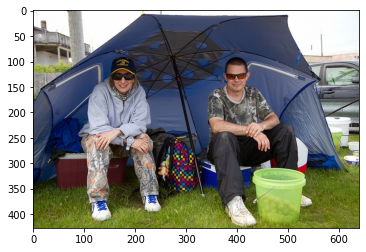

Predicted caption:   a man is standing on top of two horses that are running eee
Actual:  Woman holding tomato over item being prepared for baking.


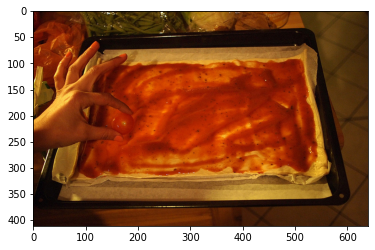

Predicted caption:   a dog laying on the carpet licking a bottle eee
Actual:  Seven jets fly in formation leaving trails of smoke behind them.


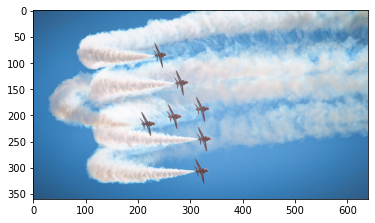

Predicted caption:   a man riding a wave on top of a surfboard eee
Actual:  A small living room with furniture and two windows.


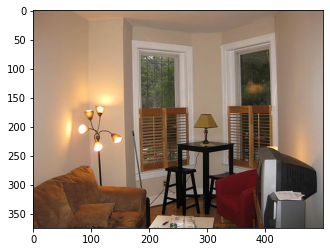

Predicted caption:   a living room with a couch a table and a panting eee
Actual:  A red double decker bus driving down a city street.


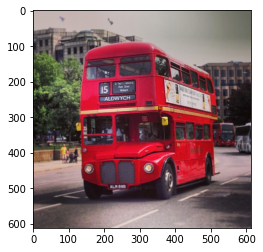

Predicted caption:   a man is walking down the sidewalk next to a bus on the street eee
Actual:  A man standing in front of a clock.


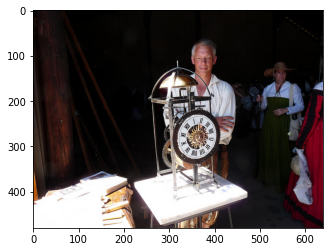

Predicted caption:   a man standing on a bench with a sign next to him eee
Actual:  Two seagulls standing on a rock looking out over the beach.


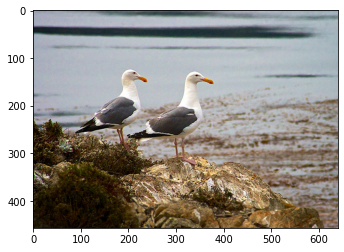

Predicted caption:   a polar bear is swimming in a pool of water eee
Actual:  A dog having his teeth brushed with a novelty electric toothbrush.


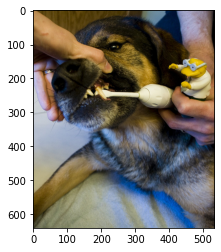

Predicted caption:   a man is leading a cow with a ribbon on its neck eee
Actual:  A cute brown puppy is snuggled on a rumpled bed.


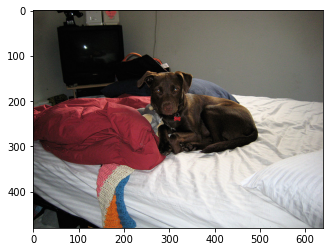

Predicted caption:   a woman is laying in bed reading a book eee
Actual:  Men stand in uniforms, expressionless, in an historic photo.


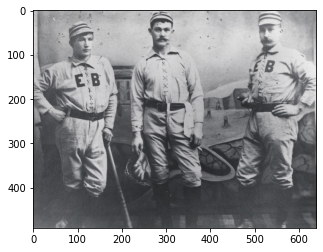

Predicted caption:   a man and a woman are playing outside eee
Actual:  An electric train is traveling down the track on a road.


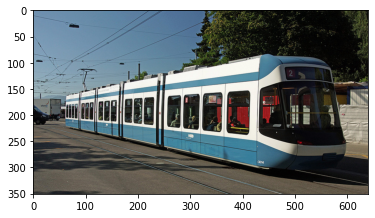

Predicted caption:   a bus parked in the street in front of a building eee
Actual:  two ladies sitting down looking at a cell phone


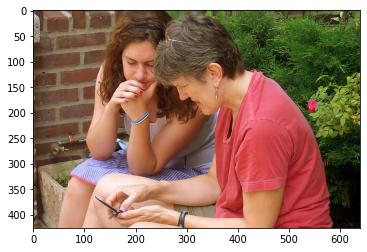

Predicted caption:   a dog sitting on a bench with a bottle of beer eee
Actual:  A man in a red t shirt riding a wave on top of a surfboard.


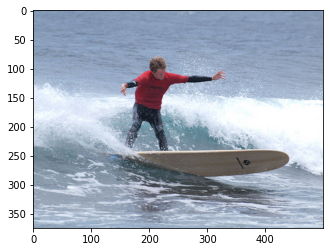

Predicted caption:   a man riding a wave on top of a surfboard eee
Actual:  Cross country skiers travel through the snow during a race.


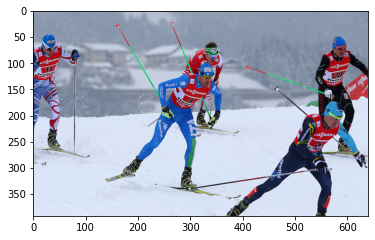

Predicted caption:   a man is about to throw a frisbee in a grassy field eee
Actual:  two men on different baseball teams getting ready for the next move. 


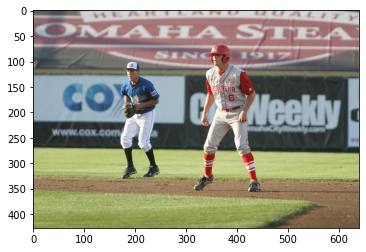

Predicted caption:   a baseball player is about to make a pitch eee
Actual:  a beach with a woman sitting in the sand guiding a kite 


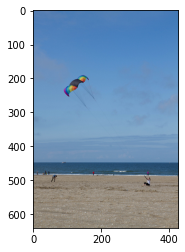

Predicted caption:   a man riding a wave on top of a surfboard eee
Actual:  Three people, two wearing blue shirts, are on the tennis court.


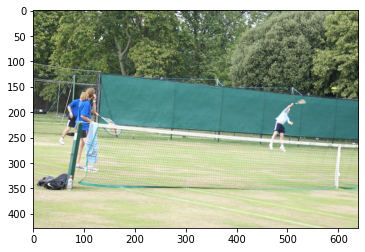

Predicted caption:   a man standing on a purple bed playing an electric guitar eee
Actual:  A professional baseball pitches is taking the mound. 


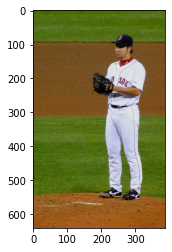

Predicted caption:   a baseball player is about to make a pitch eee
Actual:  The bulls are walking down the street in front of cars. 


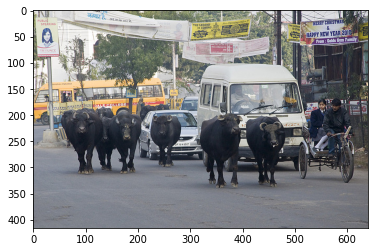

Predicted caption:   a man standing next to a traffic light in australia eee
Actual:  A young man with long hair, wearing all black, doing stunts on a skateboard.


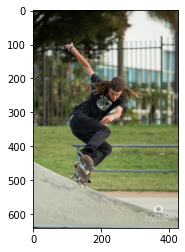

Predicted caption:   a man is playing tennis on the court racket in hand eee
Actual:  A train is passing by while an onlooker is standing next to track.


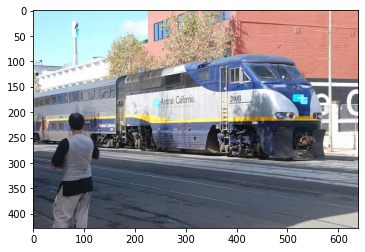

Predicted caption:   a man is walking a dog on a sidewalk eee
Actual:  A man running with a racket trying to .hit a tennis ball


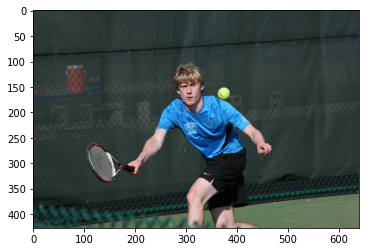

Predicted caption:   a man in a baseball uniform ready to swing at a pitch eee
Actual:  A box full of matching, ridged donuts with glaze.


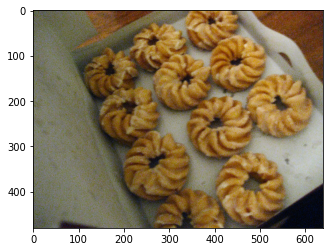

Predicted caption:   a small dog with a chain of broccoli paper from the camera eee
Actual:  a hallway next to a bedroom doorway and a blue padded chair.


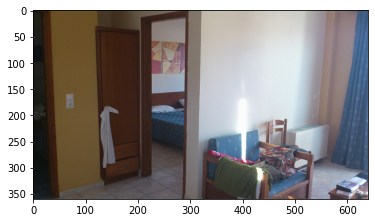

Predicted caption:   a man standing in a hallway with an umbrella and rain coming down eee
Actual:  A person standing next to a rock wall near a cat standing on it. 


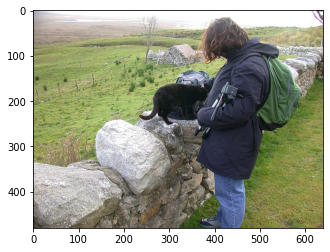

Predicted caption:   a man is using two cows to plow his head eee
Actual:  A young boy cuts into a cake shaped like a skateboard.


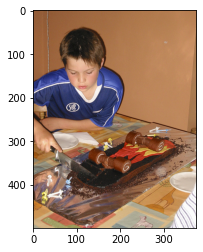

Predicted caption:   a young man stands over a lap top computer screen eee
Actual:  A quiet city street shows buildings, cars, and people.


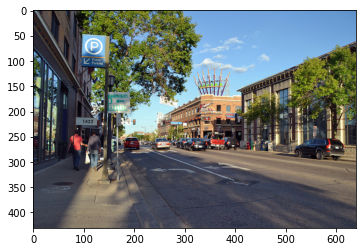

Predicted caption:   a train engine that is letting out smoke travelling down a railroad track with multiple passenger cars attached eee
Actual:  Several sheep are in a pen as some kids stand next to it while one boy has his hand on one of the sheep's head.


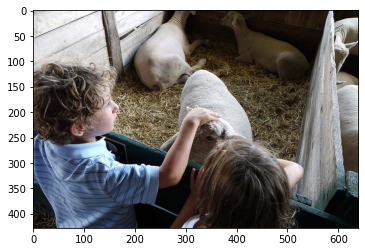

Predicted caption:   a dog and a cat are watching the plants on the table eee
Actual:  A person who is sitting and looking up at a computer monitor. 


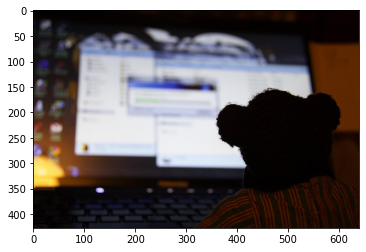

Predicted caption:   a fire hydrant that has the stars and stripes on it eee
Actual:  A very ornately decorated and brightly colored clock.


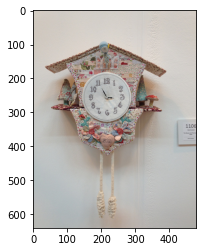

Predicted caption:   a man that is holding a kite in the sand eee
Actual:  Several baskets of different color types of fruits.


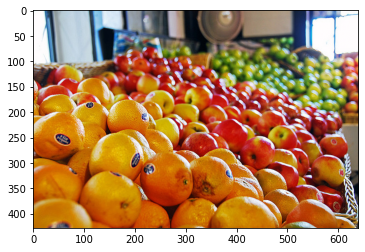

Predicted caption:   a table full of different foods such as pizza fries and a sandwich eee
Actual:  A man who is playing tennis on a tennis court.


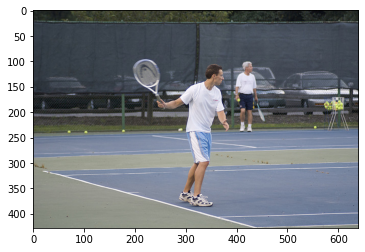

Predicted caption:   a man standing on a tennis court holding a tennis racket eee
Actual:  A small bathroom with marble tiles and counter.


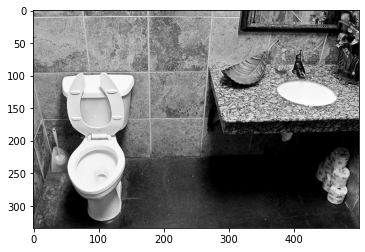

Predicted caption:   a man standing in front of a mirror in a room eee
Actual:  Assortment of finished meals displayed on a table.


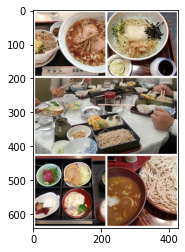

Predicted caption:   a collage displays a table with a vase of flowers on it eee
Actual:  A white toilet bowl with the lid up and seat down.


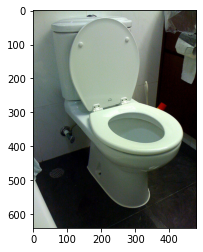

Predicted caption:   a toilet and sink that is in a bathroom eee
Actual:  A table lamp is on revealing part of a bed and an upside down glass.


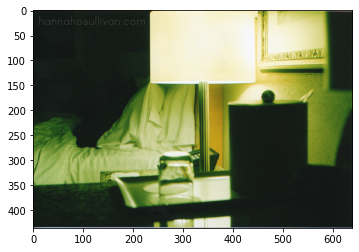

Predicted caption:   a cat is laying on a bed in front of a laptop eee
Actual:  A girl is onstage singing while the guest on the bike enjoys himself.


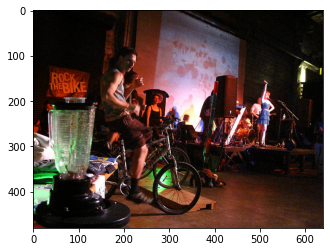

Predicted caption:   a man is holding a suitcase at a city intersection eee
Actual:  People in a store that is selling bananas and apples.


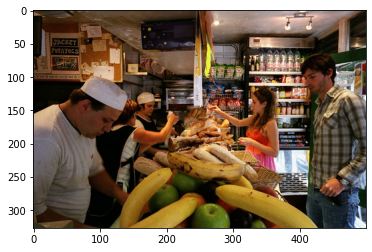

Predicted caption:   a man and a woman are standing beside a glass eee
Actual:  A cat that is checking into its Twitter account to post a tweet.


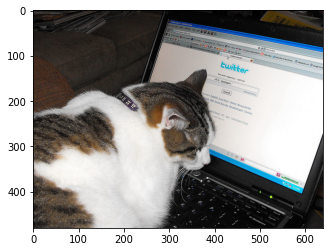

Predicted caption:   a dog is laying on a small bed eee
Actual:  A small bathroom with a closet off to the side


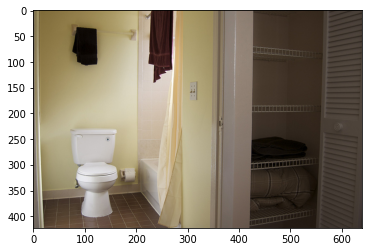

Predicted caption:   a bathroom with a toilet window and toilet tissue holder eee
Actual:  Birds and Clouds roll over a sandy beach


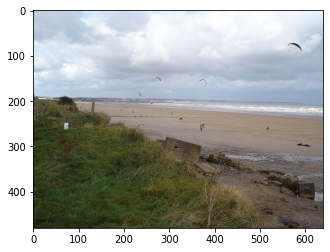

Predicted caption:   a man riding a wave on top of a surfboard eee
Actual:  a black and white photo of a street signs and buildings


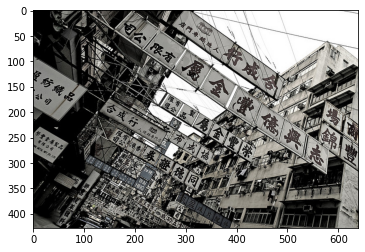

Predicted caption:   a red and white bus on street next to trees eee
Actual:  A thin wine bottle sits on a table against a wall.


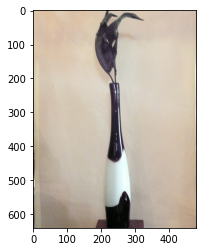

Predicted caption:   a man is standing with his hands on a snowy hill eee
Actual:  A boat out of the water on the shore with other boats in the background.


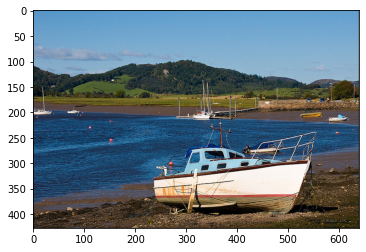

Predicted caption:   a man standing on a pair of skis and coming down a snow covered hill eee
Actual:  An athlete is performing on a sports field.


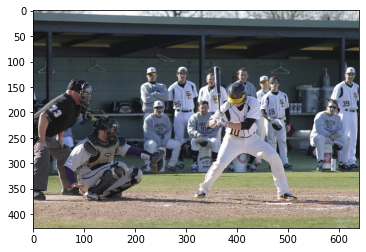

Predicted caption:   a man and a woman are playing outside eee
Actual:  a street sign attached to a wooden pole


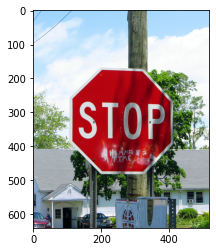

Predicted caption:   a large clock tower in the middle of a street eee
Actual:  a cabinet with some paint on top of it 


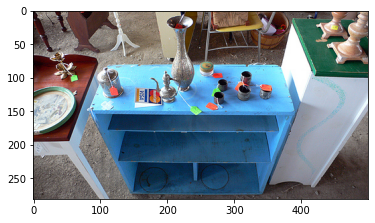

Predicted caption:   a man is laying on the back of a toilet eee
Actual:  An beautifully designed clock tower with gold and blue. 


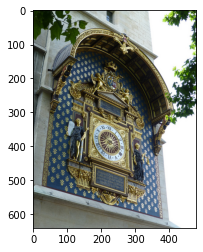

Predicted caption:   a clock that is hanging underneath a glass arch eee
Actual:  An elephant is walking forward in a field.


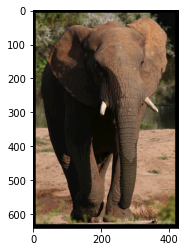

Predicted caption:   a group of people skiing down the side of a snow covered mountain eee


In [ ]:
for i in range(50):
  generate_caption(show_image(random.randint(0, num_images_test), train=False))